<a href="https://colab.research.google.com/github/fajarwr/Kaggle_LANL_Earthquake/blob/master/Kaggle_Earthquake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LANL Earthquake Prediction

## General Description
This notebook is late submission of LANL Earthquake prediction Challenge. This aim of the challenge is to predic the time remaining (time_to_failure) before earthquake spike from the given strain data (acoustic_data).

## Experimental setup
The data is retrieved from experimental setup shown in figure a as follows. The rock is forced by constant stress (pressure) and push by constant velocity to mimic the shear stress of a fault in Earth tectonic plates.

![alt text](https://wol-prod-cdn.literatumonline.com/cms/attachment/ce383c18-1ce9-48b0-994f-e090415d1e51/grl51070-fig-0001-m.jpg)

## Data and additional information
The challenge information can be accesed here [link text](https://www.kaggle.com/c/LANL-Earthquake-Prediction/). The file / data structure is as follows :
*   train.csv - A single, continuous training segment of experimental data.
*   test - A folder containing many small segments of test data.
*   sample_sumbission.csv - A sample submission file in the correct format.

## Solution
The solution of this challenge inspired from this link [link text](https://www.kaggle.com/lavanyadml/lanl-earthquake-prediction). General step of this solution is as follows :
1.   Load the datasets.
2.   Exploratory Data Analysis
3.   Feature Engineering
4.   Train and Validate some models.
5.   Make a prediction
6.   Save a submission

# Step 1 : Load the datasets.

In [0]:
#Install kaggle package to access kaggle datasets
!pip install kaggle

In [0]:
#Directory processing
import os
#math operations
import numpy as np
#data preprocessing
import pandas as pd
#Import prety plot
import seaborn as sns
#Import light gradient boosting machine
import lightgbm as lgb
#data visualization
import matplotlib.pyplot as plt
#Load cross validation
from sklearn.model_selection import KFold
#data scaling
from sklearn.preprocessing import StandardScaler
#hyperparameter optimization
from sklearn.model_selection import GridSearchCV
#Gradient Boost for Regression
from sklearn.ensemble import GradientBoostingRegressor as GBR




#machine learning
#from catboost import CatBoostRegressor, Pool
#support vector machine model
#from sklearn.svm import NuSVR, SVR
#kernel ridge model
#from sklearn.kernel_ridge import KernelRidge

In [0]:
#Make kaggle API to access the datasets
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes


In [0]:
#Download the LANL Earthquake Challange and unzip
!rm -r sample_data
!kaggle competitions download -c LANL-Earthquake-Prediction
!unzip train.csv.zip
!unzip test.zip -d test
!rm *.zip
!ls

  0% 0.00/33.3k [00:00<?, ?B/s]
100% 33.3k/33.3k [00:00<00:00, 29.9MB/s]
 98% 238M/242M [00:02<00:00, 101MB/s]
100% 242M/242M [00:02<00:00, 94.8MB/s]
100% 2.02G/2.03G [00:30<00:00, 54.5MB/s]
100% 2.03G/2.03G [00:30<00:00, 71.6MB/s]
Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.zip
  inflating: test/seg_430e66.csv     
  inflating: test/seg_d1a281.csv     
  inflating: test/seg_05a1b0.csv     
  inflating: test/seg_f8dd7e.csv     
  inflating: test/seg_b9bdd7.csv     
  inflating: test/seg_24c1c9.csv     
  inflating: test/seg_c5abaa.csv     
  inflating: test/seg_6262c4.csv     
  inflating: test/seg_734a88.csv     
  inflating: test/seg_94a133.csv     
  inflating: test/seg_d0c280.csv     
  inflating: test/seg_d36737.csv     
  inflating: test/seg_f80e44.csv     
  inflating: test/seg_07c815.csv     
  inflating: test/seg_7c9433.csv     
  inflating: test/seg_211486.csv     
  inflating: test/seg_78ded2.csv     
  inflating: test/seg_f11f77.csv     
  i

# Step 2 : Exploratory Data Analyst

In [0]:
#How many files in test folder
cwd = os.getcwd()
print("There are {} files in the test folder".format(len(os.listdir(os.path.join(cwd, 'test' )))))

There are 2624 files in the test folder


In [0]:
#Get the first 10^9 entries and print the first 10 data imported
nrows = 10**9
train_df = pd.read_csv(os.path.join(cwd,'train.csv'), nrows=nrows, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
print("Train: rows:{} cols:{}".format(train_df.shape[0], train_df.shape[1]))
pd.options.display.precision = 20
print(train_df.head(10))

Train: rows:629145480 cols:2
   acoustic_data         time_to_failure
0             12  1.46909998320000001470
1              6  1.46909998210000014573
2              8  1.46909998099999983268
3              5  1.46909997990000018575
4              8  1.46909997879999987269
5              8  1.46909997770000000372
6              9  1.46909997659999991271
7              7  1.46909997550000004374
8             -5  1.46909997439999995272
9              3  1.46909997330000008375


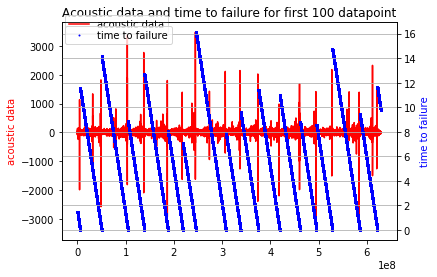

In [0]:
#Visualize first 10^9 datapoints and sampling each 100 data
#fig, ax1 = plt.subplots(figsize=(12, 8))
fig, ax1 = plt.subplots()
plt.title('Acoustic data and time to failure for first 100 datapoint')
plt.plot(train_df.index.values[::100], train_df['acoustic_data'].values[::100], color='r')
ax1.set_ylabel('acoustic data', color='r')
plt.legend(['acoustic data'], loc=(0.01, 0.95))
#plt.legend(['acoustic data'])
ax2 = ax1.twinx()
plt.scatter(train_df.index.values[::100],train_df['time_to_failure'].values[::100], color='b', s = 1)
ax2.set_ylabel('time to failure', color='b')
plt.legend(['time to failure'], loc=(0.01, 0.9))
#plt.legend(['time to failure'])
plt.grid(True)

# Step 3 : Features Engineering
The training data containing a single, continuous training segment of experimental data with time to failur for each accoustic data.
The testing data consist 150000 rows for each segment and there are 2624 segments in test folder.
So, we split the training data into several segments with 150000 rows for each segment.
A y_train will be created by taking the last row of the time to failure for each segment.

In [0]:
# Step 3 - Feature Engineering and signifiance of these statistical features

# Create a function to extract features
def gen_features(X):
    features = []
    features.append(X.mean())
    features.append(X.std())
    features.append(X.min())
    features.append(X.max())
    features.append(X.kurtosis())
    features.append(X.skew())
    features.append(np.quantile(X,0.01))
    features.append(np.quantile(X,0.05))
    features.append(np.quantile(X,0.95))
    features.append(np.quantile(X,0.99))
    features.append(np.abs(X).max())
    features.append(np.abs(X).mean())
    features.append(np.abs(X).std())
    features.append(X.values[0])
    features.append(X.values[-1])
    
    return pd.Series(features)

In [0]:
#Reload train_df where iterator = True
train_df = pd.read_csv('train.csv', iterator=True, chunksize=150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()
for df in train_df:
    ch = gen_features(df['acoustic_data'])
    X_train = X_train.append(ch, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
X_train.columns = ['mean', 'std', 'min', 'max', 'kurtosis', 'skew', 'q0.01',
                   'q0.05', 'q0.95', 'q0.99', 'abs_max', 'abs_mean', 'abs_std', 'values[0]', 'values[-1]']

In [0]:
#Check the features result
print(X_train.shape)
print(X_train.head(10))
print(X_train.describe())

(4195, 15)
                     mean                     std  ...  values[0]  values[-1]
0  4.88411333333333352869  5.10110613060676509889  ...       12.0         0.0
1  4.72576666666666689309  6.58882378194680118355  ...        5.0         5.0
2  4.90639333333333294007  6.96739703352443129347  ...        5.0         3.0
3  4.90223999999999993094  6.92230518718011289536  ...        5.0         5.0
4  4.90871999999999975017  7.30111018975881709281  ...       12.0        11.0
5  4.91351333333333339937  5.43411111286039272272  ...       14.0         3.0
6  4.85566000000000030923  5.68782339505190837059  ...        0.0         5.0
7  4.50542666666666669073  5.85451156972071284912  ...        3.0         3.0
8  4.71783333333333310122  7.78964311307998436007  ...        1.0         3.0
9  4.73095999999999961005  6.89045915266771125118  ...        5.0         4.0

[10 rows x 15 columns]
                            mean  ...                 values[-1]
count  4195.00000000000000000000  ...  419

In [0]:
#Scalled the features and check the result
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
print(X_train_scaled.head(10))

                     mean  ...              values[-1]
0  1.42426235654343358306  ... -0.69107450293592675994
1  0.80576651098418061725  ...  0.07978742532832898415
2  1.51128715933304991204  ... -0.22855734597737331626
3  1.49506440285850539240  ...  0.07978742532832898415
4  1.52037502772729871126  ...  1.00482173924543594090
5  1.53909759900370191055  ... -0.22855734597737331626
6  1.31312475681091078705  ...  0.07978742532832898415
7 -0.05487285376737274789  ... -0.22855734597737331626
8  0.77477922333616966455  ... -0.22855734597737331626
9  0.82605146651174043981  ... -0.07438496032452217299

[10 rows x 15 columns]


In [0]:
#Load the submission file and prepare the X_test file
submission = pd.read_csv('sample_submission.csv', index_col='seg_id')
print(submission.shape, X_test.shape)

(2624, 1) (2624, 15)


In [0]:
#Load the X_test
X_test = pd.DataFrame()
for seg_id in submission.index:
    seg = pd.read_csv('test/' + seg_id + '.csv', dtype={'acoustic_data': np.int16})
    ch = gen_features(seg['acoustic_data'])
    X_test = X_test.append(ch, ignore_index=True)

X_test.shape
X_test.columns = ['mean', 'std', 'min', 'max', 'kurtosis', 'skew', 'q0.01',
                   'q0.05', 'q0.95', 'q0.99', 'abs_max', 'abs_mean', 'abs_std', 'values[0]', 'values[-1]']

In [0]:
#Scaled X_test
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
X_test_scaled.shape
X_test_scaled.head(5)

,mean,std,min,max,kurtosis,skew,q0.01,q0.05,q0.95,q0.99,abs_max,abs_mean,abs_std,values[0],values[-1]
0,-0.10817619646945100809,-0.19453286234532798926,0.27990625967817467368,-0.17780388336932273496,-0.55953066619562963346,0.42289394755639769796,0.22861142682572960227,0.07875428227859368469,-0.09827706517849786605,-0.16323945502820438880,-0.18543353152190067412,-0.21278201908025223821,-0.19764464181905239126,-0.08116593482042142038,0.54230458228688249722
1,-1.36053133272436488355,-0.07349808274125084473,0.03467542034100617315,-0.04222199108105383070,-0.17127524681473157986,0.35550844003900755608,-0.05497253040830018395,0.07875428227859368469,-0.09827706517849786605,-0.02263035577935024190,-0.06079213953955268229,-0.23009853034887109424,-0.08452601574027389375,0.07891450550476329651,-0.22855734597737331626
2,0.35460201872417645985,0.04694876725199690487,-0.16528203327237736553,0.30955805377499523434,1.33032835154154249757,0.63380086284323966517,0.01592345890020726781,0.07875428227859368469,-0.09827706517849786605,-0.02263035577935024190,0.26260174236059347086,0.03284873771684921478,0.05149302138020970393,0.55915582648031747492,0.07978742532832898415
3,0.04686440072067087070,-0.28621225575311531886,0.21199618109249723785,-0.28773514738683808600,-0.38364399480160760181,-0.13381105032763243590,0.44129939475125196102,0.50496109922847576268,-0.52240369284559529106,-0.44445765352591271036,-0.25954462945735085055,-0.38624599541270265846,-0.25980393035512688860,-0.40132681547079085416,0.69647696793973357110
4,-1.52775852707353920756,-0.08827838415889334434,0.00826594533546495293,0.04938739560020894565,0.15940226568813262165,-0.10867945506458880078,0.08681944820871471957,0.07875428227859368469,-0.52240369284559529106,-0.09293490540377731535,0.02342501720527703779,-0.31411437537702363576,-0.09073254552614588853,0.07891450550476329651,-0.07438496032452217299


# Step 4 : Train and Validate some models.

In [0]:
# Make cross validation
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
train_columns = X_train_scaled.columns.values

In [0]:
#Make a hyper parameters
params = {'num_leaves': 51,
         'min_data_in_leaf': 10, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.001,
         "boosting": "gbdt",
         "feature_fraction": 0.91,
         "bagging_freq": 1,
         "bagging_fraction": 0.91,
         "bagging_seed": 42,
         "metric": 'mae',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": -1,
         "random_state": 42}

In [0]:
#Training and validation process
oof = np.zeros(len(X_train_scaled))
predictions = np.zeros(len(X_test_scaled))
feature_importance_df = pd.DataFrame()
#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_scaled,y_train.values)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = X_train_scaled.iloc[trn_idx], X_train_scaled.iloc[val_idx]
    y_tr, y_val = y_train.iloc[trn_idx], y_train.iloc[val_idx]

    model = lgb.LGBMRegressor(**params, n_estimators = 20000, n_jobs = -1)
    model.fit(X_tr, y_tr, 
                    eval_set=[(X_tr, y_tr), (X_val, y_val)], eval_metric='mae',
                    verbose=1000, early_stopping_rounds=200)
    oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += model.predict(X_test_scaled, num_iteration=model.best_iteration_) / folds.n_splits

fold 0
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 2.12008	valid_1's l1: 2.3349
[2000]	training's l1: 1.82883	valid_1's l1: 2.22022
[3000]	training's l1: 1.67289	valid_1's l1: 2.20281
Early stopping, best iteration is:
[3452]	training's l1: 1.61592	valid_1's l1: 2.20137
fold 1
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 2.12393	valid_1's l1: 2.30281
[2000]	training's l1: 1.82884	valid_1's l1: 2.18003
[3000]	training's l1: 1.66848	valid_1's l1: 2.1575
Early stopping, best iteration is:
[3146]	training's l1: 1.64889	valid_1's l1: 2.15687
fold 2
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 2.12383	valid_1's l1: 2.33319
[2000]	training's l1: 1.83238	valid_1's l1: 2.18675
[3000]	training's l1: 1.67068	valid_1's l1: 2.16295
Early stopping, best iteration is:
[3216]	training's l1: 1.64177	valid_1's l1: 2.16249
fold 3
Training until validation scores don't improve for 200 r

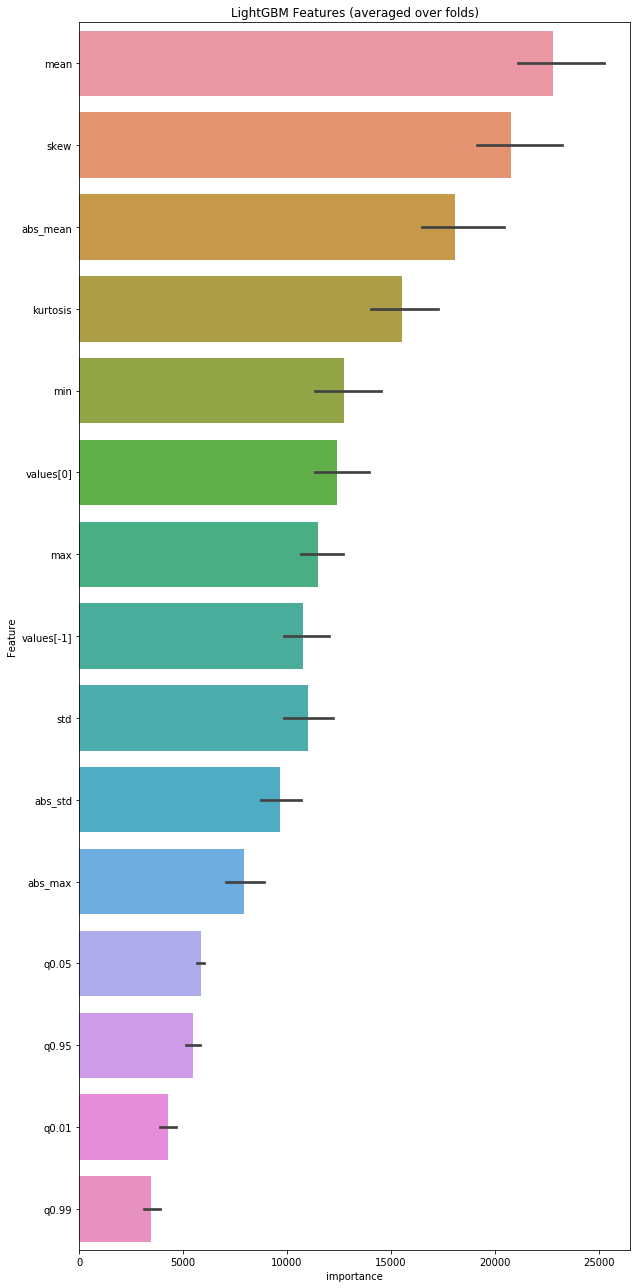

In [0]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:200].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(9,18))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()

In [0]:
submission.time_to_failure = predictions
submission.to_csv('submission.csv',index=True)

In [0]:
submission

,time_to_failure
seg_id,
seg_00030f,5.09181093104047821640
seg_0012b5,5.52854436326347453701
seg_00184e,4.62430300895881352119
seg_003339,8.80969998311834601168
seg_0042cc,6.77817519439890503463
seg_004314,2.92195881988385641748
seg_004cd2,7.29603211008903684842
seg_004ee5,3.13448182877033687532
seg_004f1f,4.15651535991457876662
